In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [3]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [4]:
train_df = pd.read_csv('train.csv', dtype={7: 'str'})
test_df = pd.read_csv('test.csv', dtype={7: 'str'})

In [5]:
print(train_df.head())
print(test_df.head(60000))

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
          Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0   

In [6]:
train_df = train_df.dropna()

In [7]:
test_df = test_df.fillna(0)

In [8]:
import pandas as pd
import logging

In [9]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [10]:
def remove_outliers(df, column):
    if column not in df.columns:
        logger.error(f"Column '{column}' not found in DataFrame.")
        raise KeyError(f"Column '{column}' does not exist in dataset.")
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    logger.info(f"Outliers removed from column '{column}'. Original rows: {len(df)}, Remaining: {len(filtered_df)}")
    return filtered_df

In [11]:
if 'Sales' in train_df.columns:
    train_df = remove_outliers(train_df, 'Sales')
else:
    logger.warning("Column 'Sales' not found in train dataset. Skipping outlier removal.")

2025-10-21 17:01:53,039 - INFO - Outliers removed from column 'Sales'. Original rows: 1017209, Remaining: 990515


In [12]:
print("Data after removing outliers:")
print(train_df.head())
print(test_df.head())

Data after removing outliers:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0             0
1   2      3          4  2015-09-17   1.0      1            0             0
2   3      7          4  2015-09-17   1.0      1            0             0
3   4      8          4  2015-09-17   1.0      1            0             0
4

In [13]:
train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])


In [14]:
def add_date_features(df, date_col='Date'):
    df['day'] = df[date_col].dt.day
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['weekday'] = df[date_col].dt.weekday # 0=Mon
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    df['weekofyear'] = df[date_col].dt.isocalendar().week.astype(int)
    df['dayofyear'] = df[date_col].dt.dayofyear
    df['is_month_start'] = df[date_col].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_col].dt.is_month_end.astype(int)
    # Beginning/Mid/End of month bands
    df['month_band'] = pd.cut(df['day'], bins=[0,10,20,31], labels=['start','mid','end'])
    return df

In [15]:
train_df = add_date_features(train_df)
test_df = add_date_features(test_df)


In [16]:
def convert_to_bool(df):
    if 'IsHoliday' in df.columns and df['IsHoliday'].dtype != 'bool':
        df['IsHoliday'] = df['IsHoliday'].astype(bool)
    return df

In [17]:
train_df = convert_to_bool(train_df)
test_df = convert_to_bool(test_df)

In [18]:
if 'IsHoliday' in train_df.columns:
    holiday_dates_train = sorted(train_df.loc[train_df['IsHoliday'], 'Date'].dt.date.unique())
else:
    holiday_dates_train = []

if 'IsHoliday' in test_df.columns:
    holiday_dates_test = sorted(test_df.loc[test_df['IsHoliday'], 'Date'].dt.date.unique())
else:
    holiday_dates_test = []

In [19]:
from bisect import bisect_left

In [20]:
import bisect
import numpy as np

In [21]:
def days_to_next_holiday(date, holiday_list):
    # date is datetime.date
    i = bisect.bisect_left(holiday_list, date)
    if i >= len(holiday_list):
        return np.nan
    return (holiday_list[i] - date).days

def days_since_prev_holiday(date, holiday_list):
    i = bisect.bisect_left(holiday_list, date)
    if i == 0:
        return np.nan
    return (date - holiday_list[i-1]).days

In [22]:
train_df['days_to_next_holiday'] = train_df['Date'].dt.date.apply(lambda d: days_to_next_holiday(d, holiday_dates_train))
train_df['days_since_prev_holiday'] = train_df['Date'].dt.date.apply(lambda d: days_since_prev_holiday(d, holiday_dates_train))

In [23]:
test_df['days_to_next_holiday'] = test_df['Date'].dt.date.apply(lambda d: days_to_next_holiday(d, holiday_dates_test))
test_df['days_since_prev_holiday'] = test_df['Date'].dt.date.apply(lambda d: days_since_prev_holiday(d, holiday_dates_test))

In [24]:
if 'CompetitionOpenSinceYear' in train_df.columns:
    train_df['CompetitionOpenSinceYear'] = train_df['CompetitionOpenSinceYear'].replace(0, np.nan)
if 'CompetitionOpenSinceMonth' in train_df.columns:
    train_df['CompetitionOpenSinceMonth'] = train_df['CompetitionOpenSinceMonth'].replace(0, np.nan)

In [25]:
if 'CompetitionOpenSinceYear' in test_df.columns:
    test_df['CompetitionOpenSinceYear'] = test_df['CompetitionOpenSinceYear'].replace(0, np.nan)
if 'CompetitionOpenSinceMonth' in test_df.columns:
    test_df['CompetitionOpenSinceMonth'] = test_df['CompetitionOpenSinceMonth'].replace(0, np.nan)


In [26]:
columns_to_check = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']

for col in columns_to_check:
    if col in train_df.columns:
        train_df[col] = train_df[col].replace(0, np.nan)
    if col in test_df.columns:
        test_df[col] = test_df[col].replace(0, np.nan)

In [27]:
if 'Open' in train_df.columns:
    train_df = train_df[train_df['Open'] != 0].copy()

In [28]:
if 'Sales' in train_df.columns:
    train_df.loc[:, 'Sales_log'] = np.log1p(train_df['Sales'])

In [29]:
if 'Open' in test_df.columns:
    test_df = test_df[test_df['Open'] != 0].copy()

In [30]:
if 'Sales' in test_df.columns:
    test_df.loc[:, 'Sales_log'] = np.log1p(test_df['Sales'])

In [31]:
features = [
'Store','StoreType','Assortment','CompetitionDistance','competition_open_years',
'Promo','promo2_months','IsHoliday','day','month','year','weekday','is_weekend',
'is_month_start','is_month_end','days_to_next_holiday','days_since_prev_holiday'
]

In [32]:
features = [f for f in features if f in train_df.columns]
X_train = train_df[features]
y_train = train_df['Sales_log']

In [33]:
# If you need to create X_test, you can do:
X_test = test_df[features]


In [34]:
train_idx = train_df['Date'] < train_df['Date'].max() - pd.Timedelta(days=90)
X_train, X_test = X_train[train_idx], X_train[~train_idx]
y_train, y_test = y_train[train_idx], y_train[~train_idx]


In [35]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import numpy as np

In [37]:
SEED = 42  # define your random seed

numeric_features = [c for c in X_train.columns if X_train[c].dtype in [np.float64, np.int64] and c != 'Store']
cat_features = [c for c in X_train.columns if X_train[c].dtype == 'object' or c == 'Store']

In [38]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


In [39]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [40]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, cat_features)
    ])

In [41]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1))
])


In [42]:
numeric_features = [c for c in X_train.columns if X_train[c].dtype in [np.float64, np.int64] and c != 'Store']
cat_int_features = [c for c in X_train.columns if X_train[c].dtype in [np.int64] and c == 'Store']
cat_obj_features = [c for c in X_train.columns if X_train[c].dtype == 'object']

In [43]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [44]:
cat_int_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

In [45]:
cat_obj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_int', cat_int_transformer, cat_int_features),
        ('cat_obj', cat_obj_transformer, cat_obj_features)
    ])

In [47]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1))
])

In [48]:
from sklearn.metrics import mean_squared_error


In [49]:
from sklearn.metrics import mean_squared_error
import numpy as np


In [50]:
features_to_drop = ['days_to_next_holiday', 'days_since_prev_holiday']
X_train = X_train.drop(features_to_drop, axis=1)
X_test = X_test.drop(features_to_drop, axis=1)


In [51]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)


X_train columns: Index(['Store', 'Promo', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'is_month_start', 'is_month_end'],
      dtype='object')
X_test columns: Index(['Store', 'Promo', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'is_month_start', 'is_month_end'],
      dtype='object')


In [52]:
print("Numeric features:", numeric_features)
print("Categorical integer features:", cat_int_features)
print("Categorical object features:", cat_obj_features)


Numeric features: ['Promo', 'days_to_next_holiday', 'days_since_prev_holiday']
Categorical integer features: ['Store']
Categorical object features: []


In [53]:
from sklearn.metrics import make_scorer
import numpy as np


In [54]:
def rmsle(y_true, y_pred):
    # expects raw sales
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true))**2))

In [55]:
rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [56]:
from sklearn.inspection import permutation_importance


In [57]:
print(X_test.shape)
print(y_test.shape)

(81751, 9)
(81751,)


In [61]:
print("X_train columns:", X_train.columns)
print("X_test columns:", X_test.columns)

X_train columns: Index(['Store', 'Promo', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'is_month_start', 'is_month_end'],
      dtype='object')
X_test columns: Index(['Store', 'Promo', 'day', 'month', 'year', 'weekday', 'is_weekend',
       'is_month_start', 'is_month_end'],
      dtype='object')


In [62]:
print("Numeric features:", numeric_features)
print("Categorical object features:", cat_obj_features)

Numeric features: ['Promo', 'days_to_next_holiday', 'days_since_prev_holiday']
Categorical object features: []


In [68]:
common_columns = list(set(X_train.columns) & set(X_test.columns))
X_train_subset = X_train[common_columns]
X_test_subset = X_test[common_columns]


In [69]:
numeric_features_subset = [feature for feature in numeric_features if feature in common_columns]
cat_obj_features_subset = [feature for feature in cat_obj_features if feature in common_columns]


In [73]:
common_columns = list(set(X_train.columns) & set(X_test.columns))
X_train_subset = X_train[common_columns]
X_test_subset = X_test[common_columns]


In [74]:
# Reorder the columns to match the pipeline
X_train_subset = X_train_subset[pipeline.feature_names_in_]
X_test_subset = X_test_subset[pipeline.feature_names_in_]

In [76]:
!pip install scikit-learn

In [79]:
from sklearn.compose import make_column_transformer

In [80]:
numeric_features = X_train_subset.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_subset.select_dtypes(include=['object']).columns

In [81]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    remainder='passthrough'
)


In [84]:
from sklearn.pipeline import make_pipeline


In [85]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

In [86]:
pipeline = make_pipeline(preprocessor, RandomForestRegressor())


In [90]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector


In [91]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), make_column_selector(dtype_include=['int64', 'float64'])),
    ('cat', OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=['object']))
])


In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
print(X_train_subset.columns)


Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8'],
      dtype='object')


2025-10-21 19:42:16,457 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:17,247 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


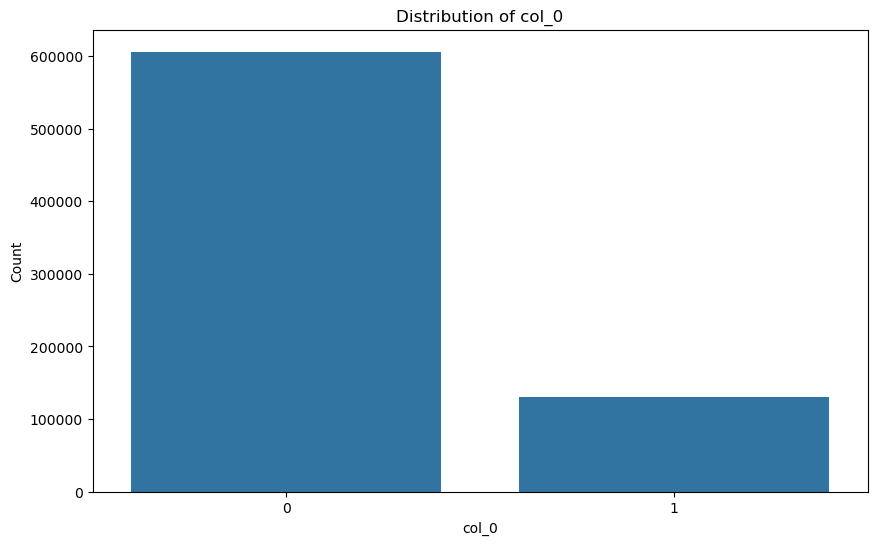

2025-10-21 19:42:19,339 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:20,186 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


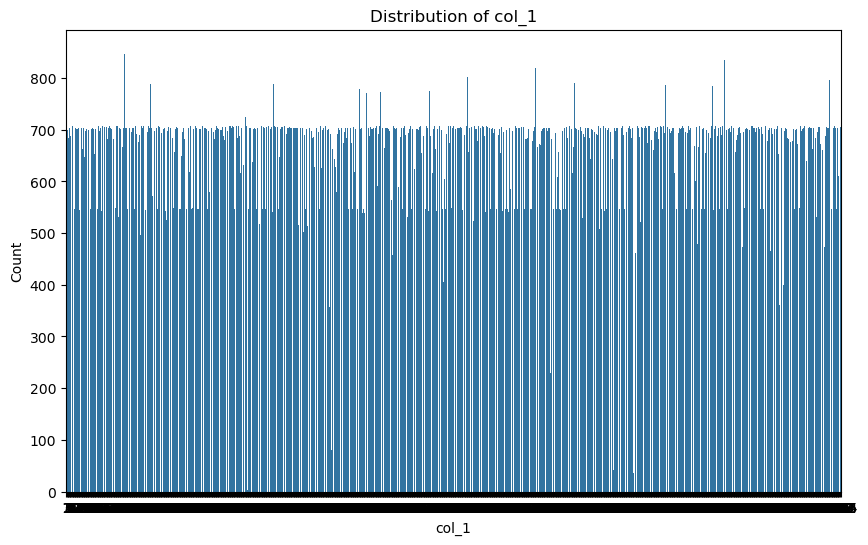

2025-10-21 19:42:37,596 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:38,459 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


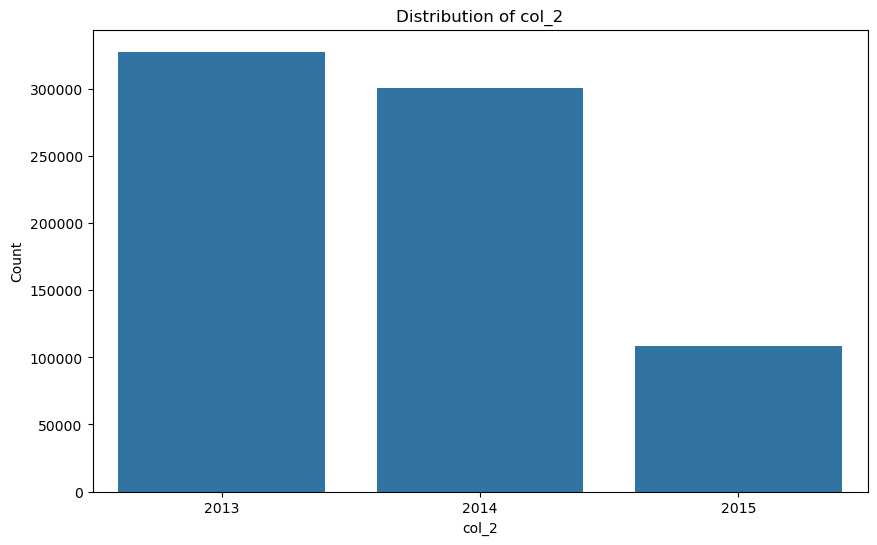

2025-10-21 19:42:40,351 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:41,148 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


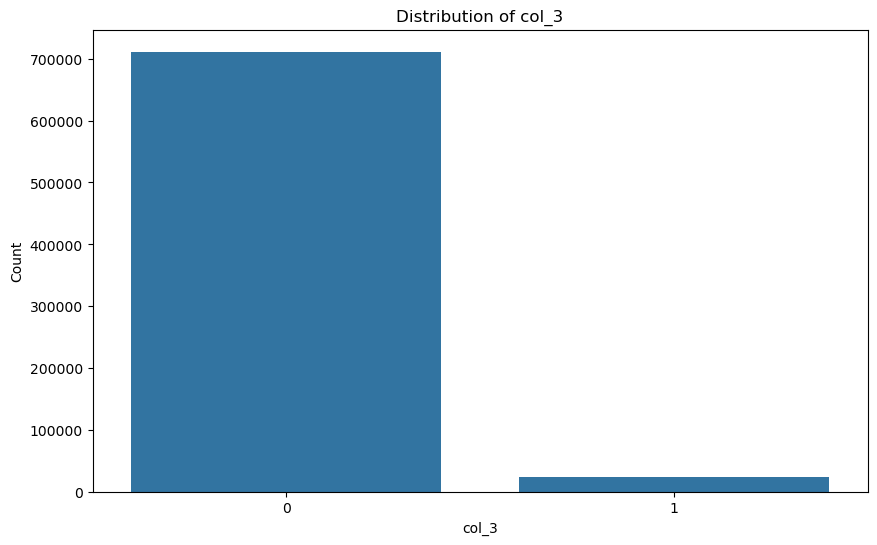

2025-10-21 19:42:42,792 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:43,530 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


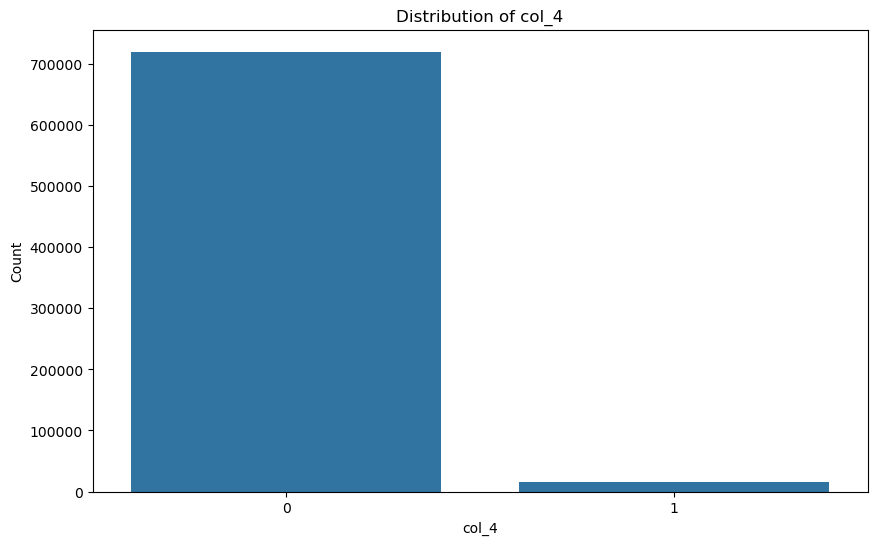

2025-10-21 19:42:45,352 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:46,073 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


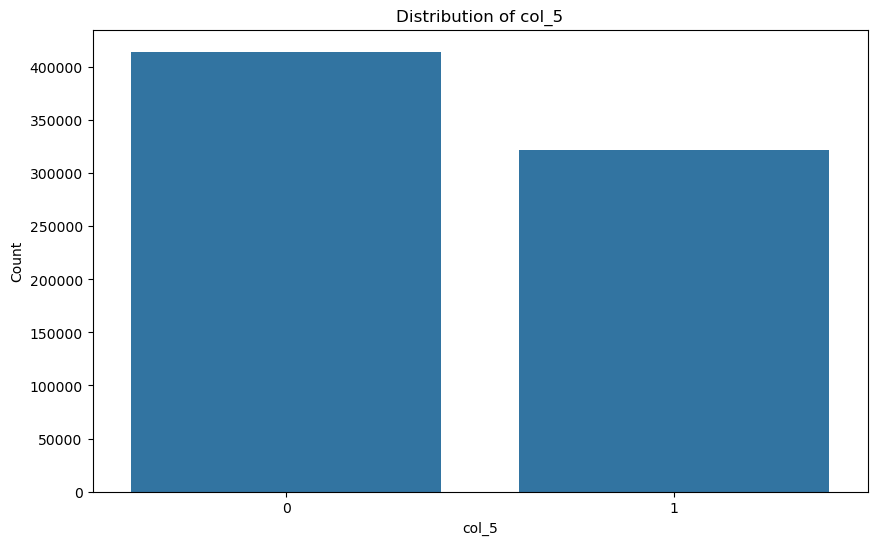

2025-10-21 19:42:47,824 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:48,591 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


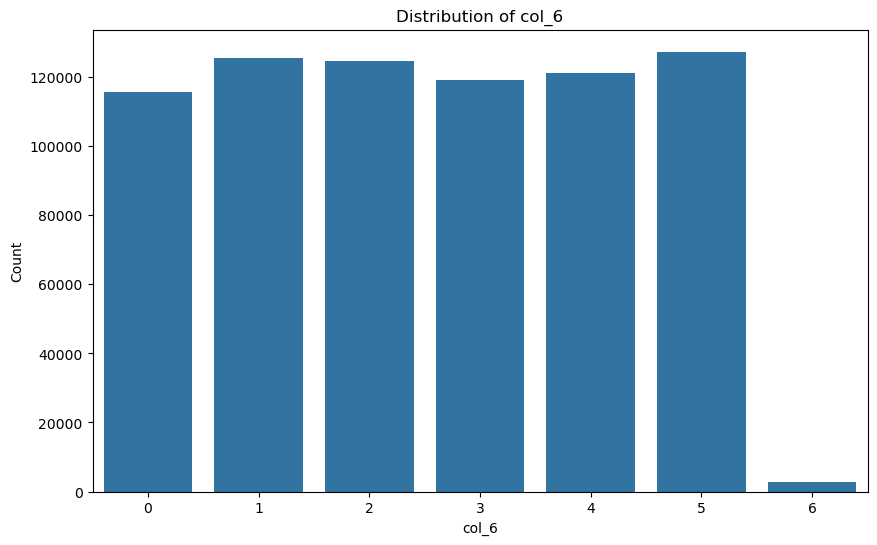

2025-10-21 19:42:50,195 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:50,962 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


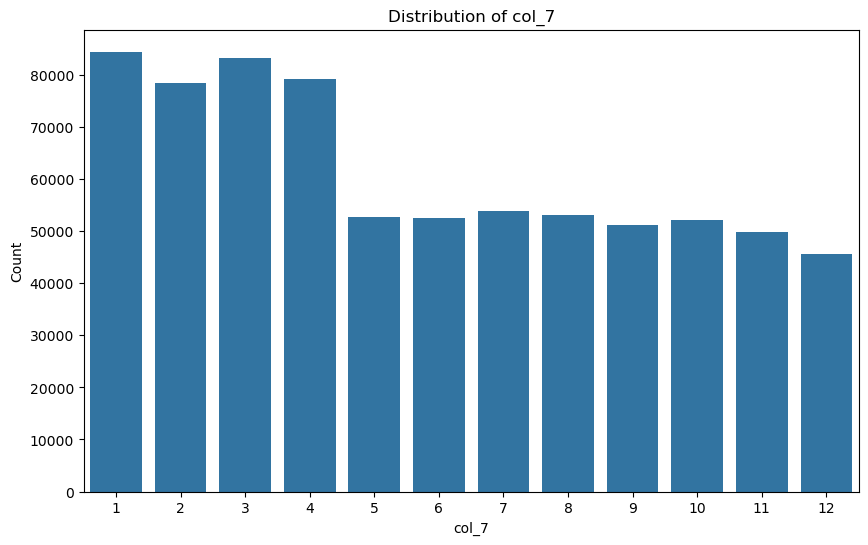

2025-10-21 19:42:52,884 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-21 19:42:53,621 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


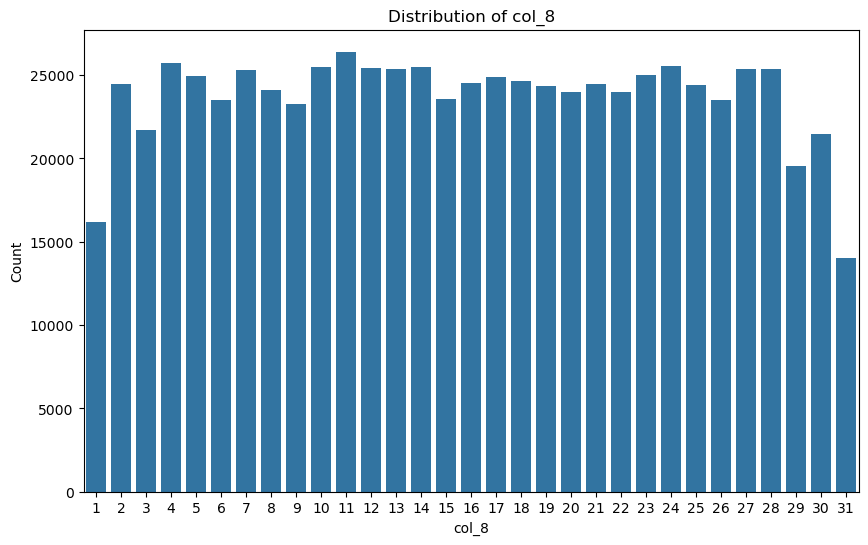

In [98]:
for column in X_train_subset.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=X_train_subset, x=column)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.show()


In [101]:
print(X_train_subset.columns)


Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8'],
      dtype='object')


In [109]:
date_column = '<column_name_representing_dates>'
holiday_column = '<column_name_representing_state_holidays>'
sales_column = '<column_name_representing_sales>'

In [112]:
date_column = 'Date'
holiday_column = 'StateHoliday'
sales_column = 'Sales'


In [113]:
print(X_train_subset.columns)

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8'],
      dtype='object')


In [115]:
date_column = 'Date'
holiday_column = 'StateHoliday'
sales_column = 'Sales'

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

In [129]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [132]:
train_df = pd.read_csv('train.csv', dtype={7: 'str'})
test_df = pd.read_csv('test.csv', dtype={7: 'str'})

In [150]:
print(train_df.head())
print(test_df.head(60000))

   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
          Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0   

In [151]:
train_df = train_df.dropna()
test_df = test_df.fillna(0)

In [152]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

In [153]:
def remove_outliers(df, column):
    if column not in df.columns:
        logger.error(f"Column '{column}' not found in DataFrame.")
        raise KeyError(f"Column '{column}' does not exist in dataset.")
    
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    logger.info(f"Outliers removed from column '{column}'. Original rows: {len(df)}, Remaining: {len(filtered_df)}")
    return filtered_df

In [154]:
if 'Column D' in X_train_subset.columns:
    X_train_subset = remove_outliers(X_train_subset, 'Column D')
else:
    logger.warning("Column 'Sales' not found in dataset. Skipping outlier removal.")

2025-10-21 21:10:04,108 - WARNING - Column 'Sales' not found in dataset. Skipping outlier removal.


In [155]:
print("Data after removing outliers:")
print(X_train_subset.head())


Data after removing outliers:
        col_0  col_1  col_2  col_3  col_4  col_5  col_6  col_7  col_8
101518      0     54   2015      0      1      1      4      5      1
101549      0     85   2015      0      1      1      4      5      1
101647      0    183   2015      0      1      1      4      5      1
101689      0    225   2015      0      1      1      4      5      1
101738      0    274   2015      0      1      1      4      5      1


In [156]:
print("Data after removing outliers:")
print(train_df.head())
print(test_df.head())

Data after removing outliers:
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1  
   Id  Store  DayOfWeek        Date  Open  Promo StateHoliday SchoolHoliday
0   1      1          4  2015-09-17   1.0      1            0             0
1   2      3          4  2015-09-17   1.0      1            0             0
2   3      7          4  2015-09-17   1.0      1            0             0
3   4      8          4  2015-09-17   1.0      1            0             0
4